# Boosting ground states preparation interfacing VQEs and DBQAs

In [1]:
# Python libraries
import copy

import numpy as np
import matplotlib.pyplot as plt

# Optimization tool
import cma

# Qibo modules
import qibo
from qibo import hamiltonians, optimizers, gates, Circuit

# Some DBI features you already know
from qibo.models.dbi.double_bracket import (
    DoubleBracketIteration,
    DoubleBracketGeneratorType,
)

# Some tools from the project repo
from boostvqe import ansatze
from boostvqe.utils import rotate_h_with_vqe
from boostvqe.models.dbi.double_bracket_evolution_oracles import (
    XXZ_EvolutionOracle,
    FrameShiftedEvolutionOracle,
    IsingNNEvolutionOracle
)

from boostvqe.models.dbi.group_commutator_iteration_transpiler import (
    DoubleBracketRotationType,
    GroupCommutatorIterationWithEvolutionOracles,
)

E0000 00:00:1733399042.942075   78488 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733399042.947722   78488 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set the qibo ML backend
qibo.set_backend("qiboml", platform="tensorflow")
plt.set_loglevel('WARNING') 

[Qibo 0.2.14|INFO|2024-12-05 12:44:06]: Using qiboml (tensorflow) backend on /device:CPU:0
INFO:qibo.config:Using qiboml (tensorflow) backend on /device:CPU:0


#### Some plotting functions

Plotting functions to:
1. visualize the Hamiltonian matrix;
2. plot the target ground state together with a given approximation;
3. plot a given loss function history.

In [3]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5), dpi=150)
    ax.set_title(title)
    # print the abs value of the components of the matrix
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)

def plot_vqe_states(state, state2=None):
    """
    Plot `state` and `state2` if provided. 
    """
    n = int(np.log2(len(state)))
    bitstrings = [format(i, f"0{n}b") for i in range(2**n)] 
    
    plt.figure(figsize=(12,4), dpi=300)
    for i, amp in enumerate(state):
        if i == 0:
            plt.bar(bitstrings[i], np.abs(amp)**2, color='#C194D8', alpha=0.7, edgecolor="black", label="Ground state")
        else:
            plt.bar(bitstrings[i], np.abs(amp)**2, color='#C194D8', alpha=0.7, edgecolor="black")
    if state2 is not None:     
        for i, amp in enumerate(state2):
            if i == 0:
                plt.bar(bitstrings[i], np.abs(amp)**2, color='black', alpha=1, edgecolor="black", hatch="\\\\", facecolor="none", label="VQE approximation")
            else:
                plt.bar(bitstrings[i], np.abs(amp)**2, color='black', alpha=1, edgecolor="black", hatch="\\\\", facecolor="none")
                
    plt.xticks(ticks=range(len(bitstrings)), labels=bitstrings, rotation=90)
    plt.xlabel("Components")
    plt.ylabel("Probabilities")
    plt.title("State representation")
    plt.legend()
    plt.show()

def plot_loss(loss_history, vqe):
    """Plot a given VQE cost function."""
    target_gs_energy = np.min(np.array(np.real(vqe.hamiltonian.eigenvalues())))
    plt.figure(figsize=(5, 5 * 6 / 8), dpi=150)
    plt.plot(loss_history, color="purple", label="Loss history", lw=1.5, alpha=0.7)
    plt.hlines(target_gs_energy, 0, len(loss_history), color="black", label="Target GS energy", lw=1.5, alpha=0.7, ls="--")
    plt.legend()
    plt.xlabel("Optimization iteration")
    plt.ylabel("Energy approximation")
    plt.show()

#### Problem setup

We consider an Hamming-weight preserving ansatz to approximate the target circuit. It is a good choice to reduce the complexity of the circuit while perfectly fulfilling the problem simmetries.

Hamming-weight preserving ansatz are made up of Reconfigurable Beam Splitters (RBS) gates, which have form:

$$ 
\text{RBS}(\theta) = 
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & \cos \theta & \sin \theta & 0 \\
    0 & -\sin \theta & \cos \theta & 0 \\
    0 & 0 & 0 & 1 
\end{bmatrix},
$$
namely, they shuffle the $01$ and $10$ components of any couple of qubits in the system, while never changing the number of ones and zeros in the total state (which is called **Hamming weight** of the bitstring). 

In [4]:
# Fix the size of the problem
nqubits = 6
nlayers = 3

In [5]:
# Build circuit
# circ0 = ansatze.hdw_efficient(nqubits=nqubits, nlayers=nlayers)
circ0 = ansatze.hw_preserving(nqubits=nqubits, nlayers=nlayers)
circ0.draw()

# We save a copy of the circuit for later
circ = circ0.copy(deep=True)

0:     ─X─RBS─────────────────RBS─RBS─────────RBS─────RBS─────────────────RBS ...
1:     ─X─RBS─────────RBS─────|───|───────RBS─|───────RBS─────────RBS─────|── ...
2:     ─X─────RBS─────RBS─────|───RBS─────|───|───────────RBS─────RBS─────|── ...
3:     ───────RBS─────────RBS─|───────RBS─RBS─|───RBS─────RBS─────────RBS─|── ...
4:     ───────────RBS─────RBS─|───────|───────RBS─|───────────RBS─────RBS─|── ...
5:     ───────────RBS─────────RBS─────RBS─────────RBS─────────RBS─────────RBS ...

0: ... ─RBS─────────RBS─────RBS─────────────────RBS─RBS─────────RBS─────
1: ... ─|───────RBS─|───────RBS─────────RBS─────|───|───────RBS─|───────
2: ... ─RBS─────|───|───────────RBS─────RBS─────|───RBS─────|───|───────
3: ... ─────RBS─RBS─|───RBS─────RBS─────────RBS─|───────RBS─RBS─|───RBS─
4: ... ─────|───────RBS─|───────────RBS─────RBS─|───────|───────RBS─|───
5: ... ─────RBS─────────RBS─────────RBS─────────RBS─────RBS─────────RBS─


As from the drawing, we prepare the initial state into one of the possible states with the same Hamming weight of the XXZ Hamiltonian, and then we evolve the system using a series of RBS gates.

In [6]:
# Initial parameters are zeros
default_params = circ.get_parameters()
nparams = len(default_params)
print(f" Default params: {default_params}\n nparams: {nparams}")

 Default params: [(0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,)]
 nparams: 33


In [7]:
# Build input Hamiltonian
h0 = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)

# Collect the exact ground state and the ground state energy
ground_state = h0.ground_state()
gs_energy = np.min(np.real(h0.eigenvalues()))

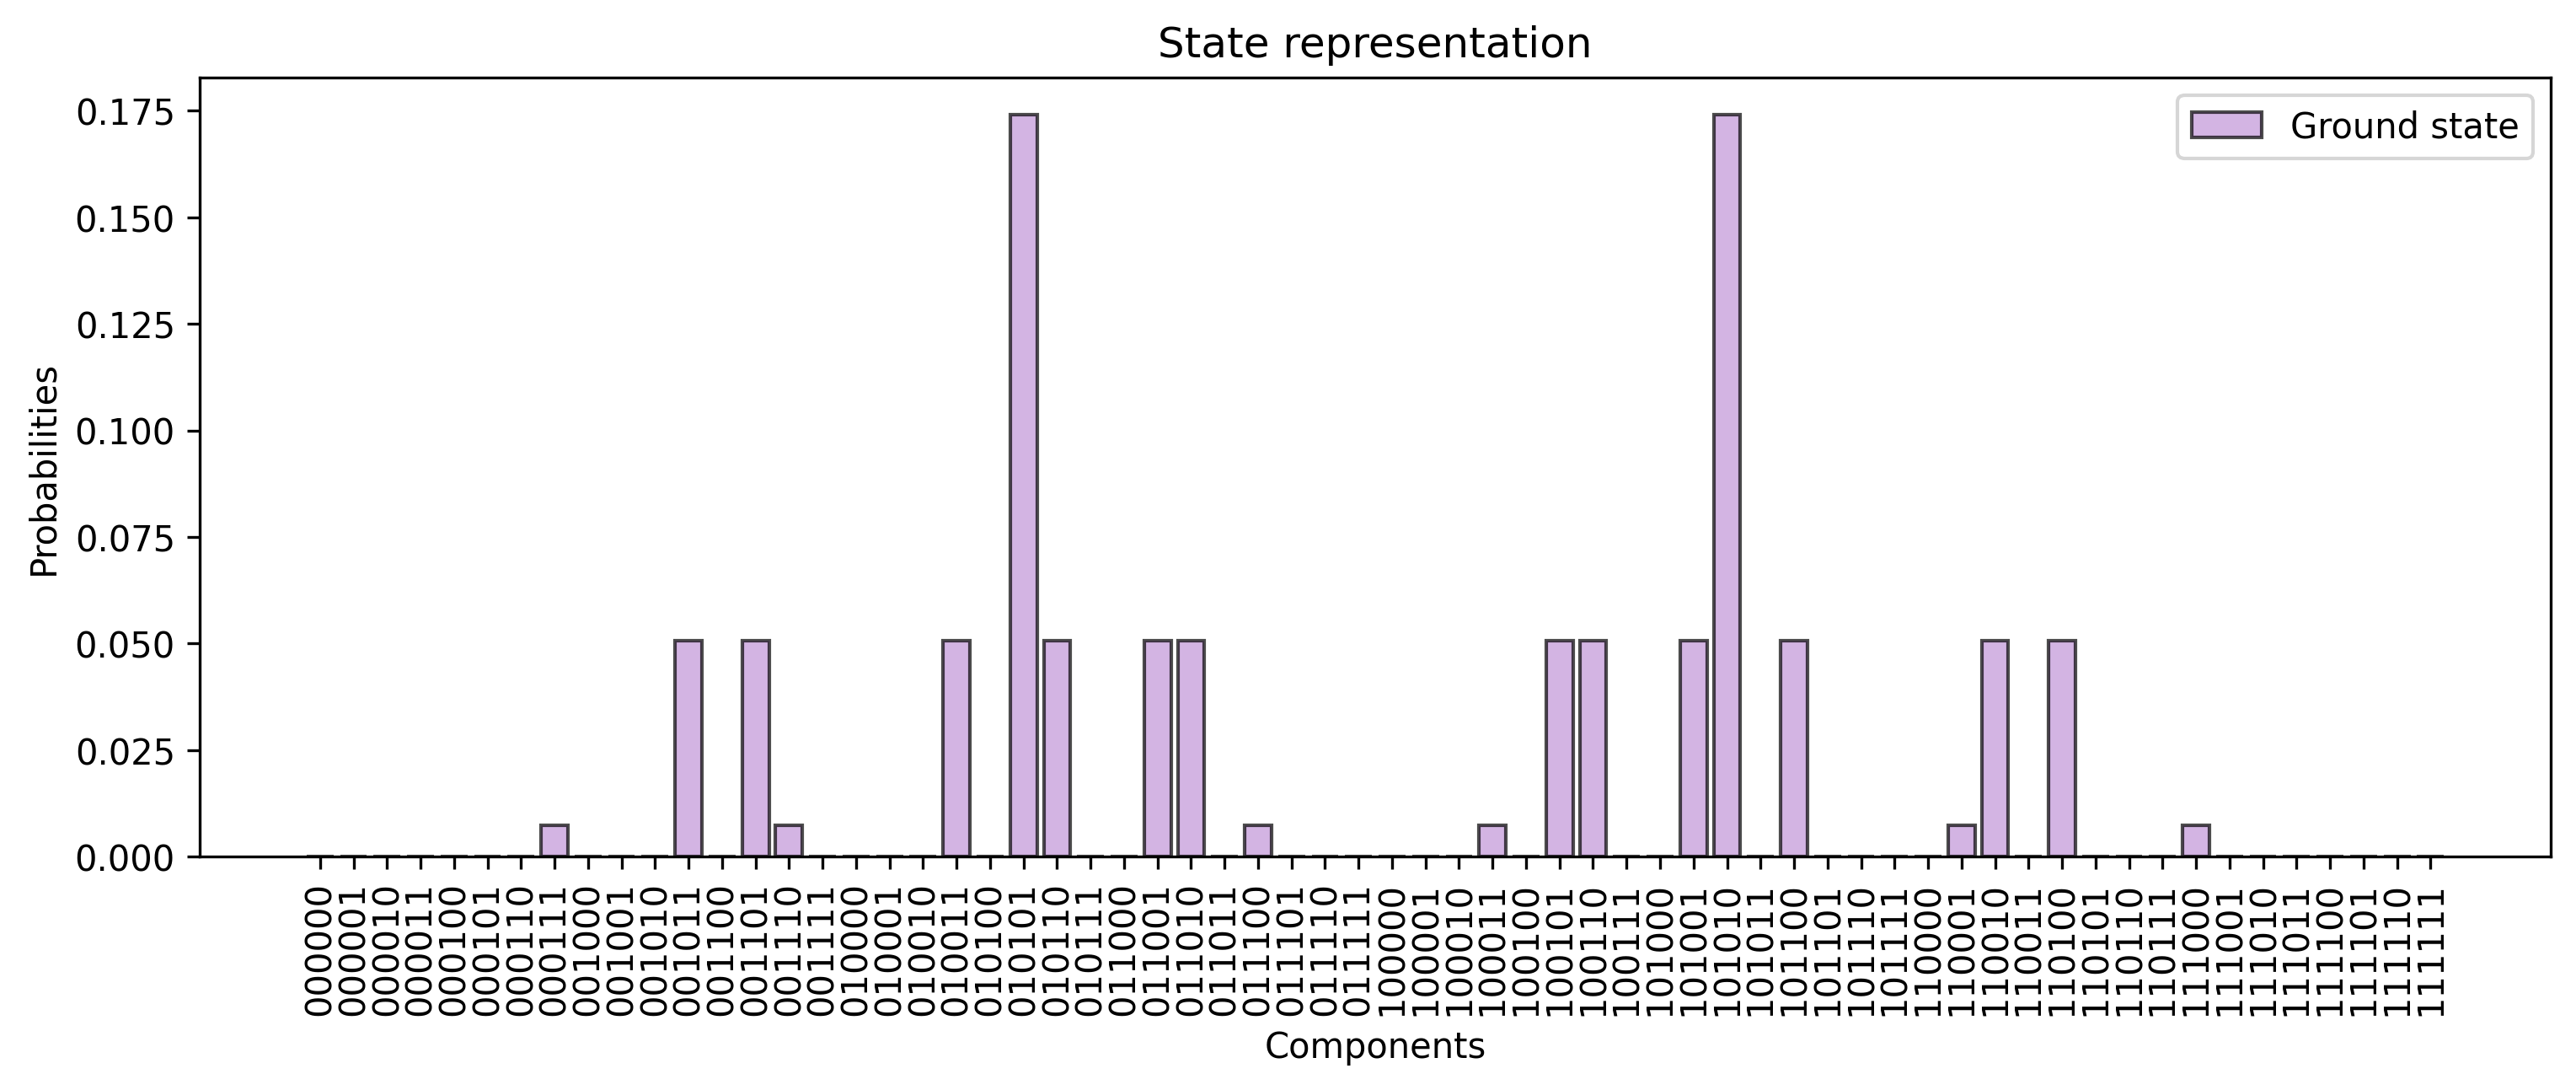

In [8]:
# Plot one (or eventually two) states
plot_vqe_states(ground_state)

In [9]:
# Initialize VQE object
vqe = ansatze.VQE(circuit=circ, hamiltonian=copy.deepcopy(h0))

#### Train the VQE

We now use the Qibo Tensorflow backend to train the VQE with a gradient descent strategy. Before doing so, let's have a look to the initial state of the circuit and its look when we fill the parameters with a randomly generater list of params from numpy RNG.

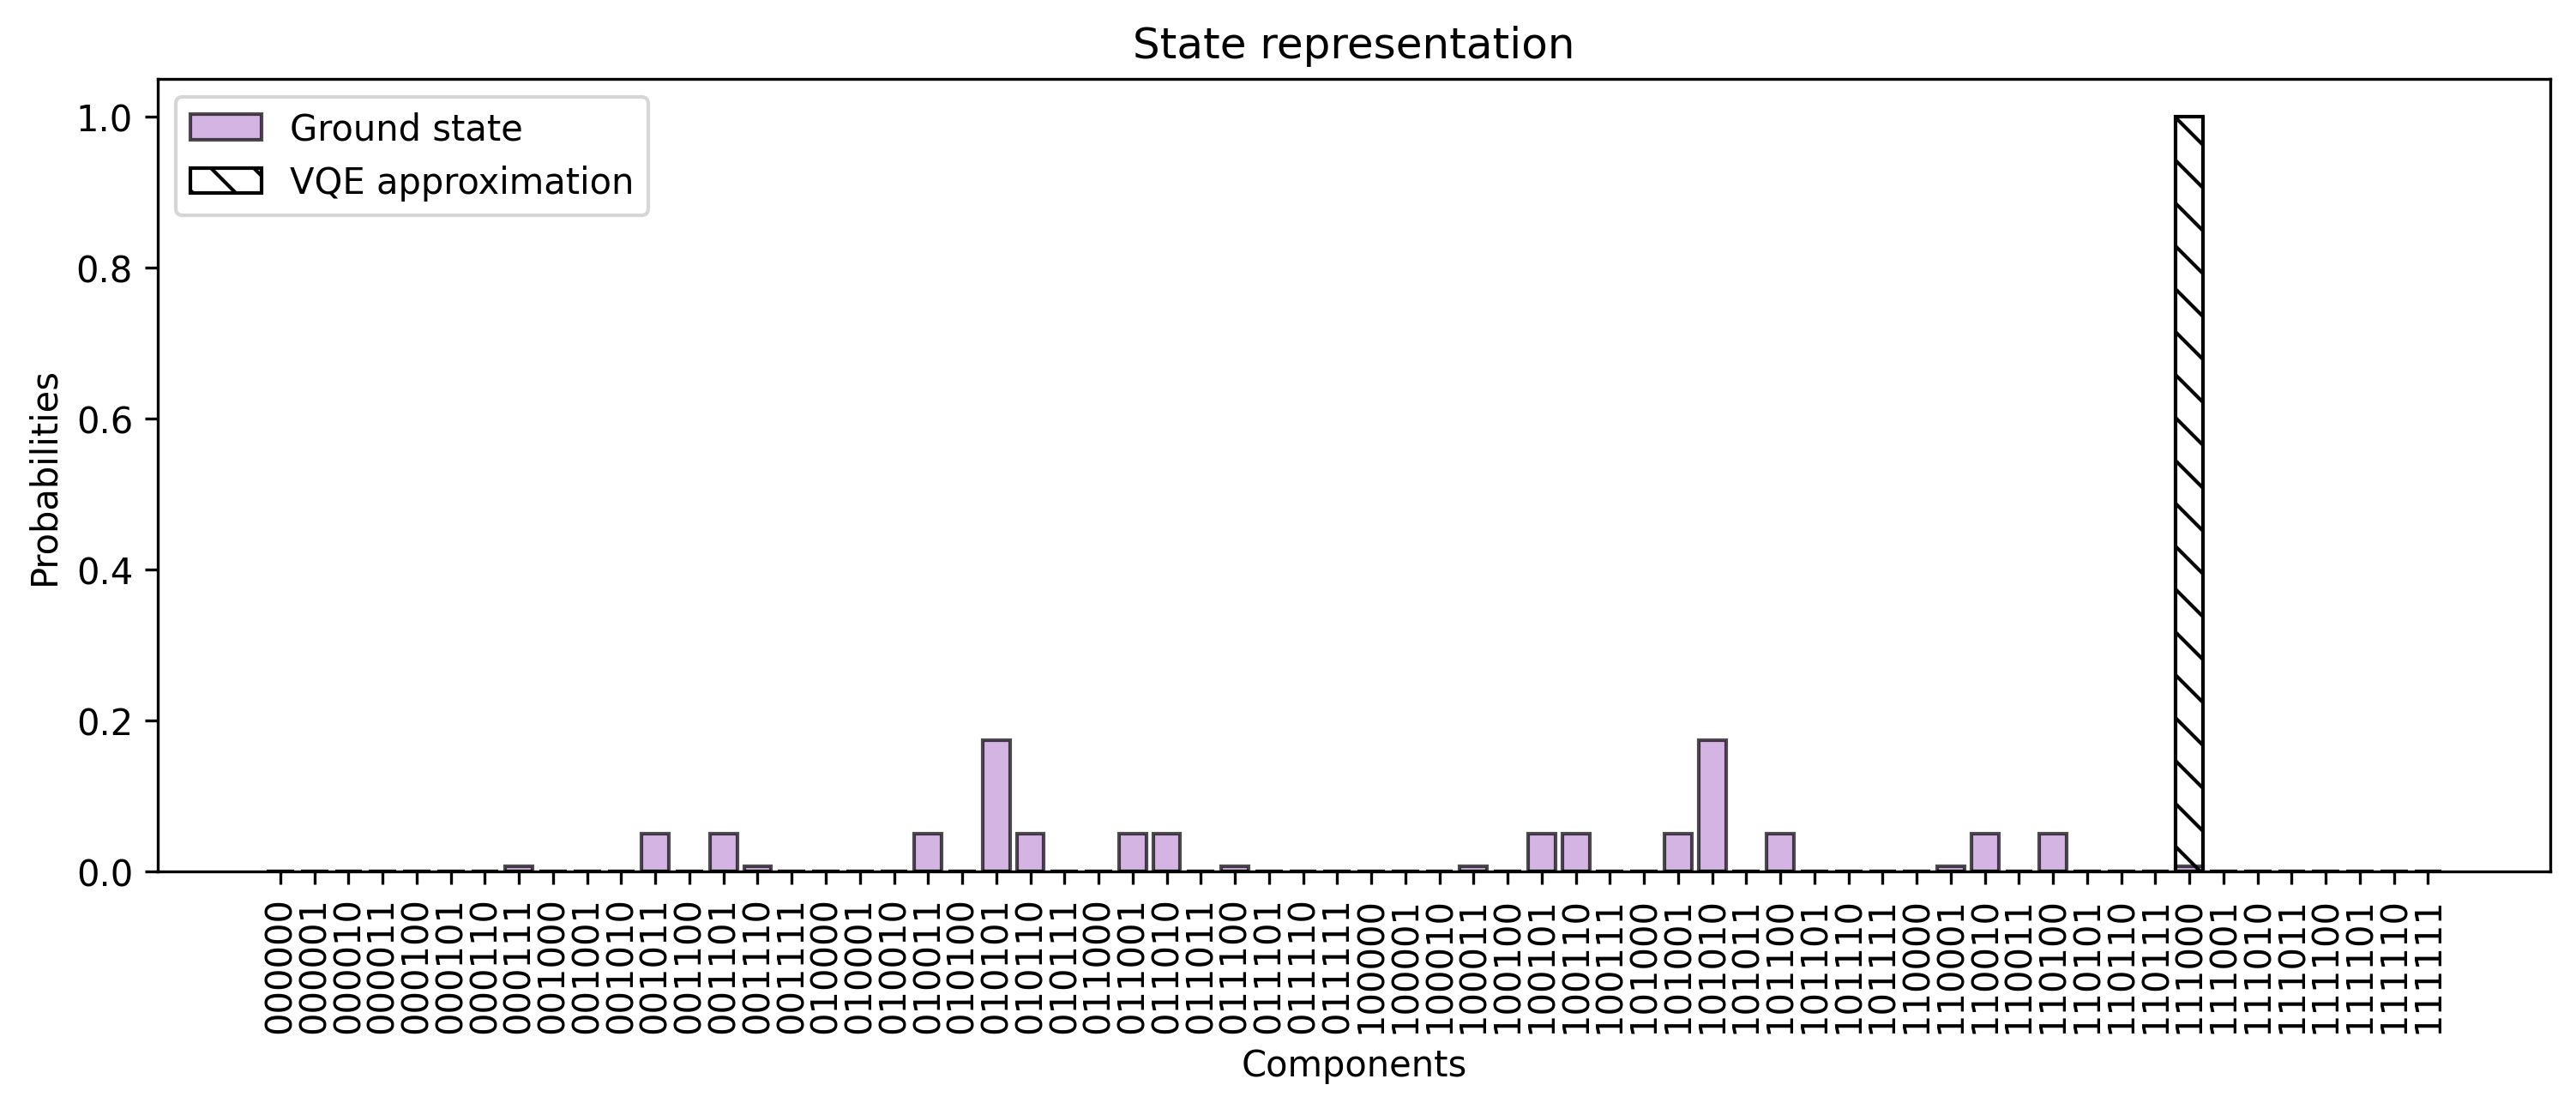

In [10]:
# VQE ground state before setting initial parameters
plot_vqe_states(ground_state, vqe.circuit().state())

The initial state is, as expected, the input state (in our case $|111000\rangle$ by choice).

In [11]:
# Set initial params
np.random.seed(42)
initial_parameters  = np.random.normal(0., 0.5, nparams)

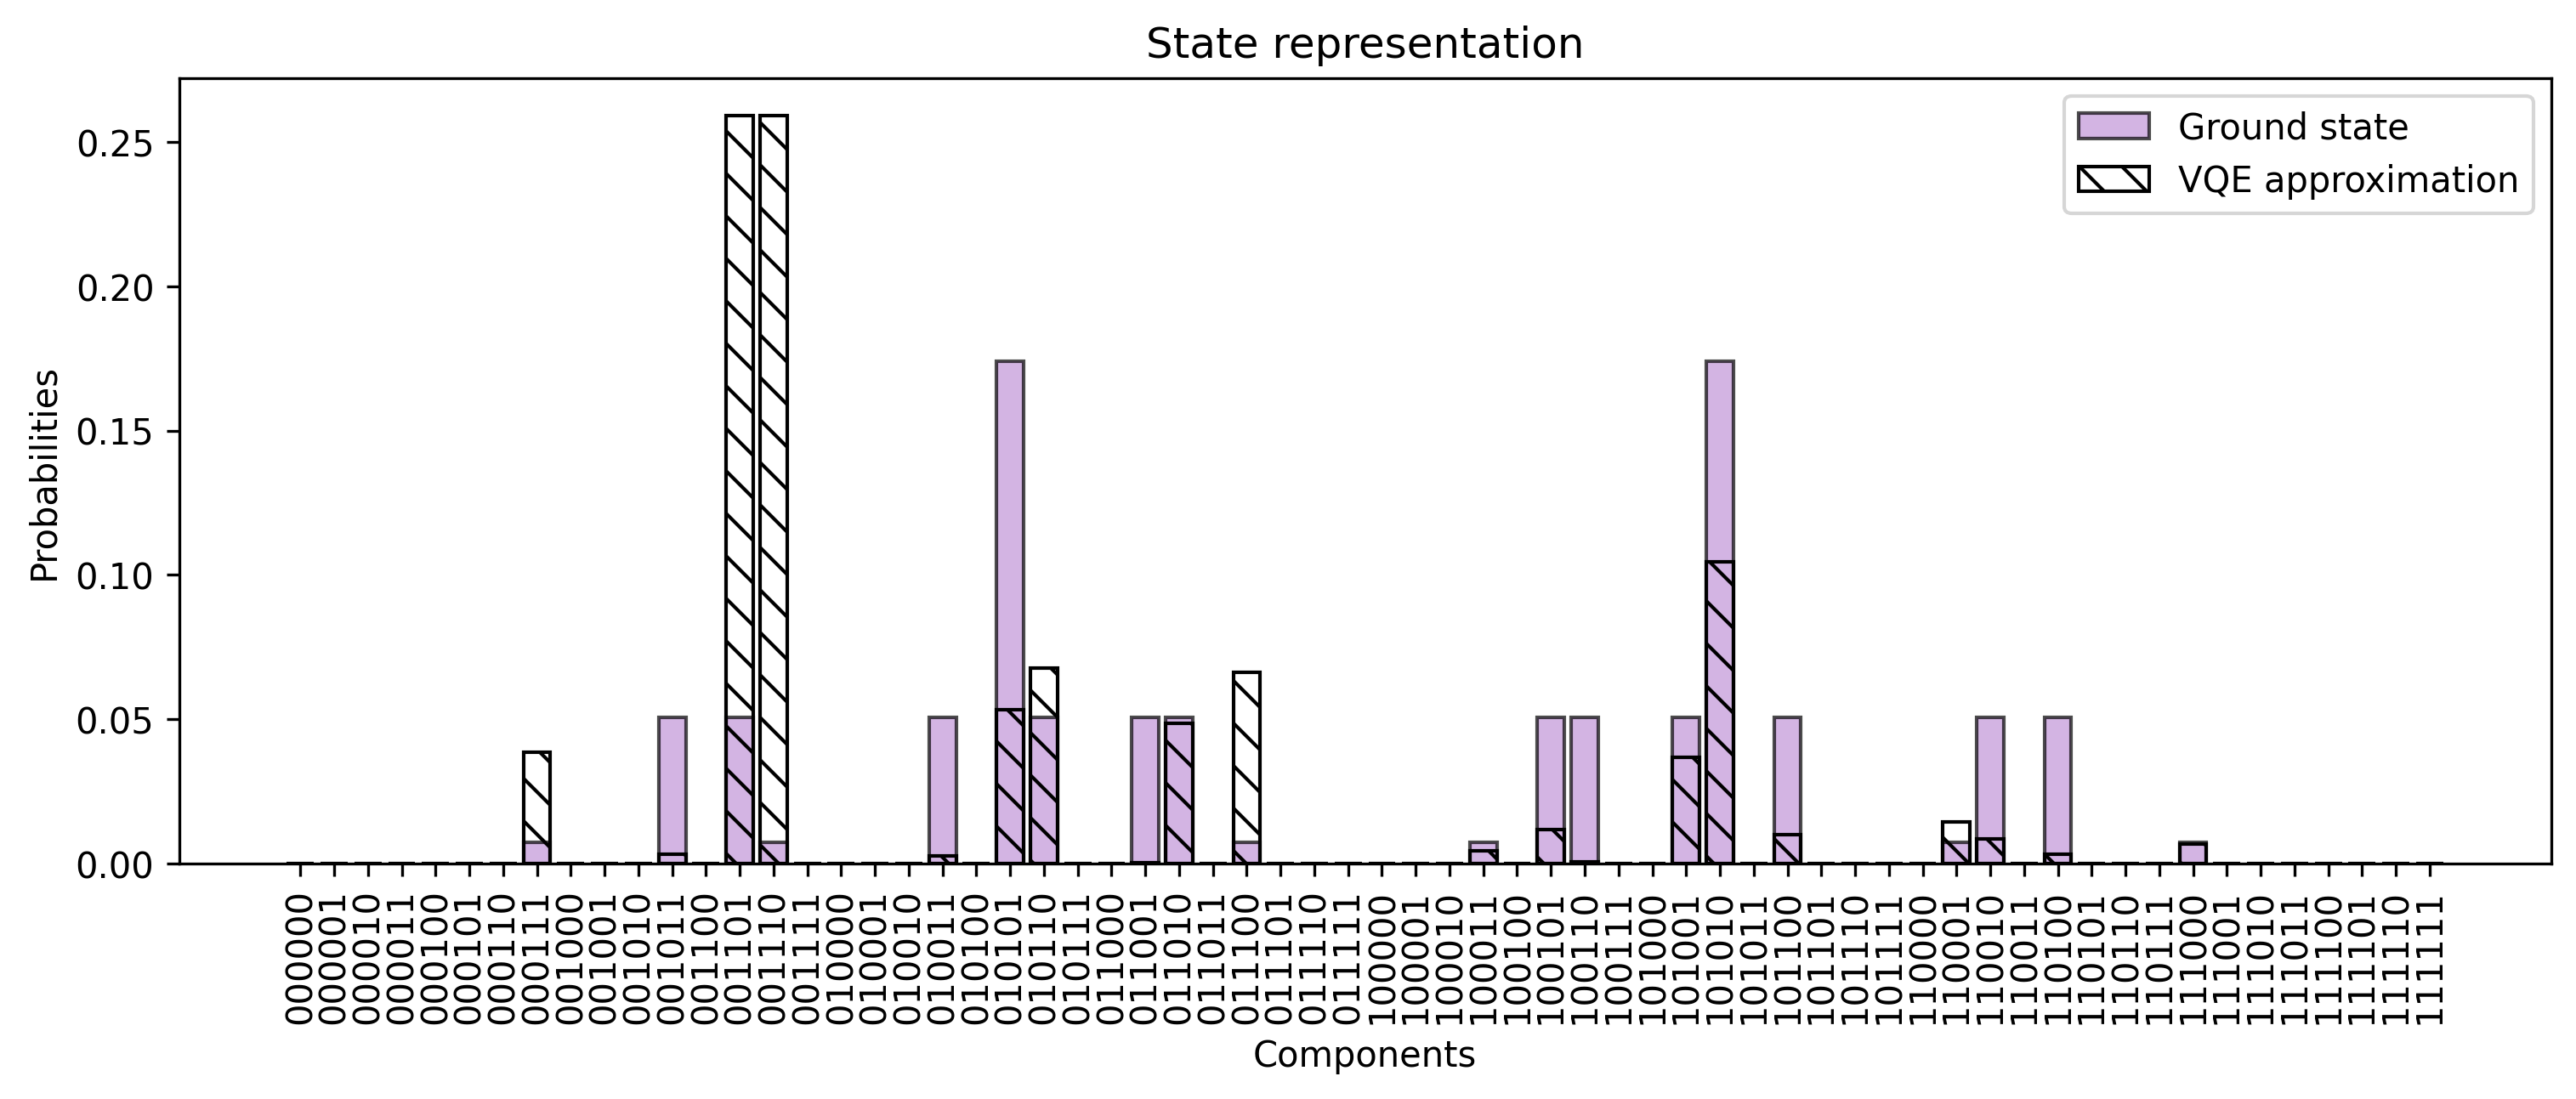

In [12]:
# Set random parameters and re-plot the states
vqe.circuit.set_parameters(initial_parameters)
plot_vqe_states(ground_state, vqe.circuit().state())

The random state doesn't approximate the ground state (as expected).

##### Defining some callbacks to keep track during optimization

We exploit the callback mechanism provided by many optimizers. Namely, we inform an optimizer that a specific function (for us will be `tracker_function`) has to be executed at every optimizer iteration.

In [13]:
# We will track the loss_history and the params history
loss_history, params_history = [], []

# Define the callback funcion
def tracker_function(
    params, 
    vqe=vqe, 
    loss_history=loss_history,
    params_history=params_history,
):
    """Keep track of loss function and VQE params history during the optimization."""
    vqe.circuit.set_parameters(params)
    loss_history.append(
        vqe.hamiltonian.expectation(
            vqe.circuit().state()
        )
    )
    params_history.append(params)
    print(f"Exec. iteration {len(loss_history)} \t Loss: {loss_history[-1]}")

# Optimization options
optimizer_options = {
    "nepochs" : 80,
    "method": "Adam",
    "nmessage": 1,
    "learning_rate": 0.05,
}

# Fix the random seed
backend = qibo.get_backend().tf.random.set_seed(42)

# Use the vqe.minimize method
opt_results = vqe.minimize(
    initial_parameters, 
    method="sgd", 
    options=optimizer_options,
    callback=tracker_function
)

Exec. iteration 1 	 Loss: -2.048737936378833
Exec. iteration 2 	 Loss: -2.8078336250077105
Exec. iteration 3 	 Loss: -3.442580728646308
Exec. iteration 4 	 Loss: -3.924925196678757
Exec. iteration 5 	 Loss: -4.2768726960189944
Exec. iteration 6 	 Loss: -4.533970478768687
Exec. iteration 7 	 Loss: -4.730147612743863
Exec. iteration 8 	 Loss: -4.891990759155335
Exec. iteration 9 	 Loss: -5.035202962003099
Exec. iteration 10 	 Loss: -5.16777585806287
Exec. iteration 11 	 Loss: -5.293963615499055
Exec. iteration 12 	 Loss: -5.416471316066531
Exec. iteration 13 	 Loss: -5.537364699614163
Exec. iteration 14 	 Loss: -5.658417443693422
Exec. iteration 15 	 Loss: -5.781239488753473
Exec. iteration 16 	 Loss: -5.90731702936312
Exec. iteration 17 	 Loss: -6.038005979038515
Exec. iteration 18 	 Loss: -6.174472227856519
Exec. iteration 19 	 Loss: -6.317546808063538
Exec. iteration 20 	 Loss: -6.467485536901492
Exec. iteration 21 	 Loss: -6.623694313885927
Exec. iteration 22 	 Loss: -6.7845490077213

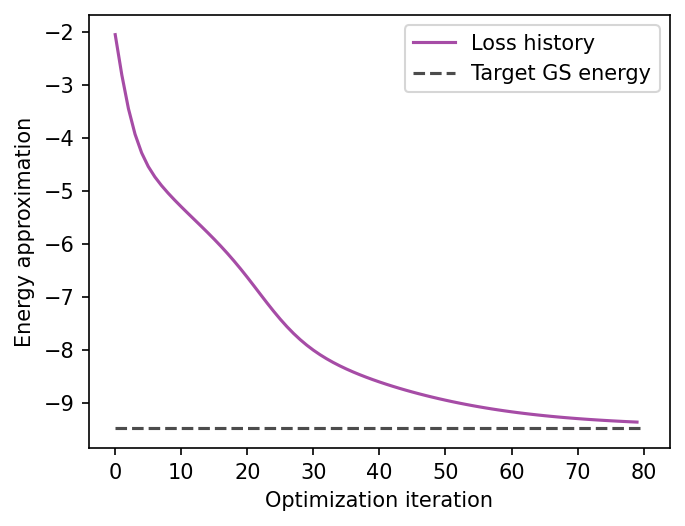

In [14]:
# Plot the loss function
plot_loss(loss_history, vqe)

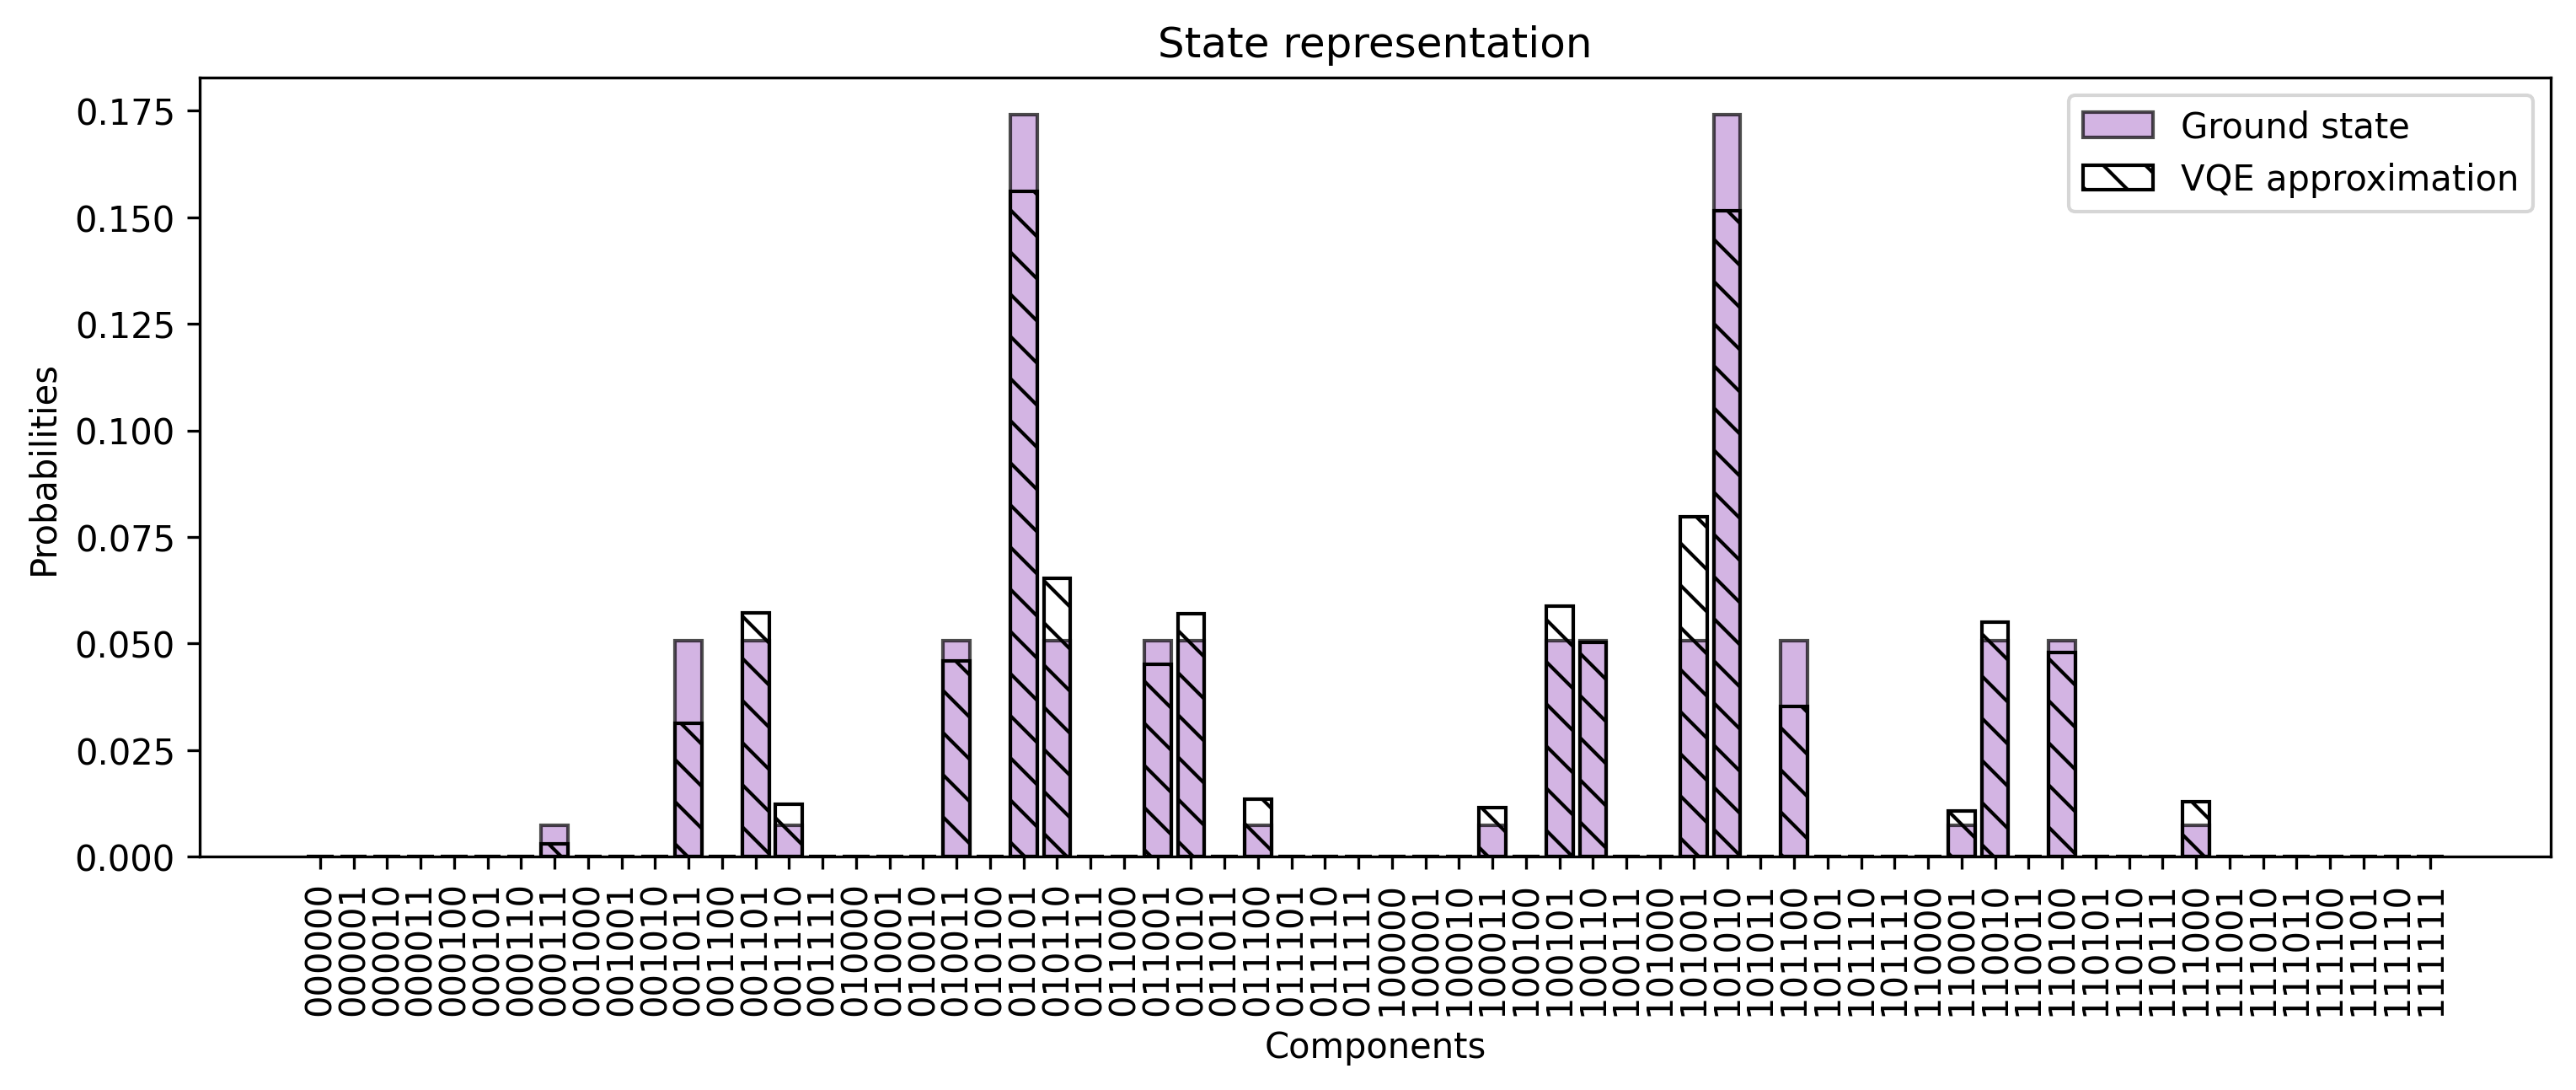

In [15]:
# Plot the VQE approximation together with the target
plot_vqe_states(ground_state, vqe.circuit().state())

#### Apply DBQA after warm start

As explained in the talk, we aim to apply a DBI to a target input of shape:
$$ \hat{A}_0 = \hat{U}^{\dagger} \hat{H}_0 \hat{U}.$$
The procedure is then analogous to the one implemented in the notebook of the last week. 
We will start by applying a DBI, while in a second moment we will move to a GCI (transpiled and compiled DBI).

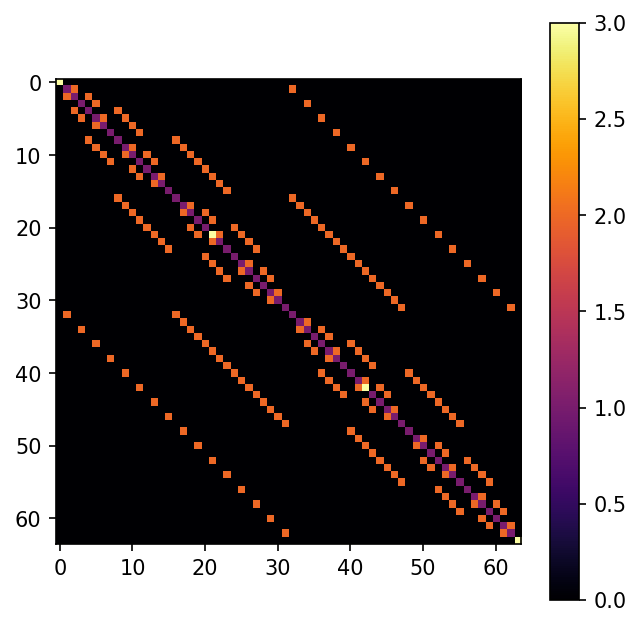

In [16]:
# Initial Hamiltonian H0
visualize_matrix(h0.matrix)

In [17]:
# We interface the VQE with the DBQA by setting A  = (U^dagger H U)
vqe_unitary = np.matrix(vqe.circuit.unitary())
rotated_h_matrix = vqe_unitary.getH() @ h0.matrix @ vqe_unitary

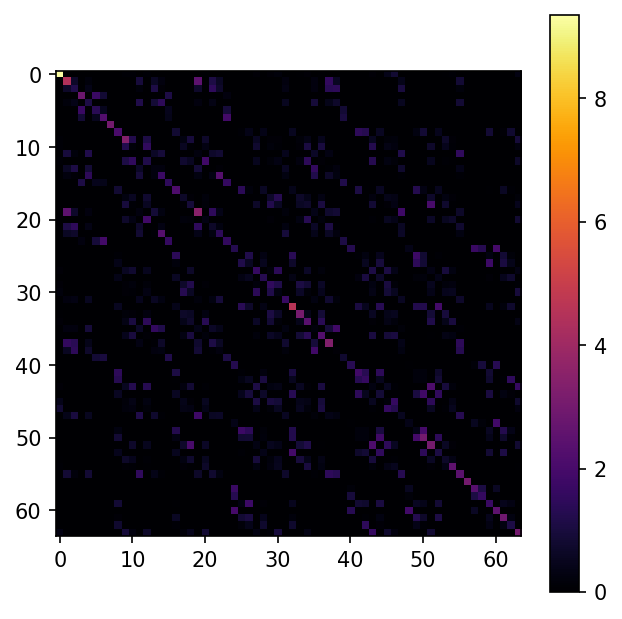

In [18]:
# Preconditioned Hamiltonian A0
visualize_matrix(rotated_h_matrix)

In [19]:
# Transform it into a Qibo hamiltonian
rotated_h = hamiltonians.Hamiltonian(nqubits=nqubits, matrix=rotated_h_matrix)

Now we can use this new input to build a DBI.

In [20]:
# Construct the DBI
dbi = DoubleBracketIteration(
    hamiltonian=rotated_h,
    mode=DoubleBracketGeneratorType.single_commutator,
)

In [21]:
# Apply three steps of DBI
operators, energies = [], []
for _ in range(3):
    dbi_op = dbi(step=0.01, d=dbi.diagonal_h_matrix)
    zero_state = np.transpose([dbi.h.backend.zero_state(dbi.h.nqubits)])
    energies.append(dbi.h.expectation(zero_state))
    # Collect DBI operators
    operators.append(dbi_op)

In [22]:
# Collect DBI operators
dbi_operators = [
    h0.backend.cast(np.matrix(h0.backend.to_numpy(operator)))
    for operator in operators
]

In [23]:
# Print energies after each DBI step
energies

[<tf.Tensor: shape=(), dtype=float64, numpy=-9.454802536479908>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-9.466958833098412>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-9.469660583818024>]

In [24]:
# Constructing a circuit containing initial VQE and DBI operators 
old_circ_matrix = circ.unitary()

circ = Circuit(nqubits)
for gate in reversed([old_circ_matrix] + operators):
    circ.add(gates.Unitary(gate, *range(nqubits), trainable=False))

In [25]:
circ.draw()

0: ─U─U─U─U─
1: ─U─U─U─U─
2: ─U─U─U─U─
3: ─U─U─U─U─
4: ─U─U─U─U─
5: ─U─U─U─U─


In [26]:
# Construct a VQE out of this circuit
vqe1 = ansatze.VQE(hamiltonian=copy.deepcopy(h0), circuit=circ)

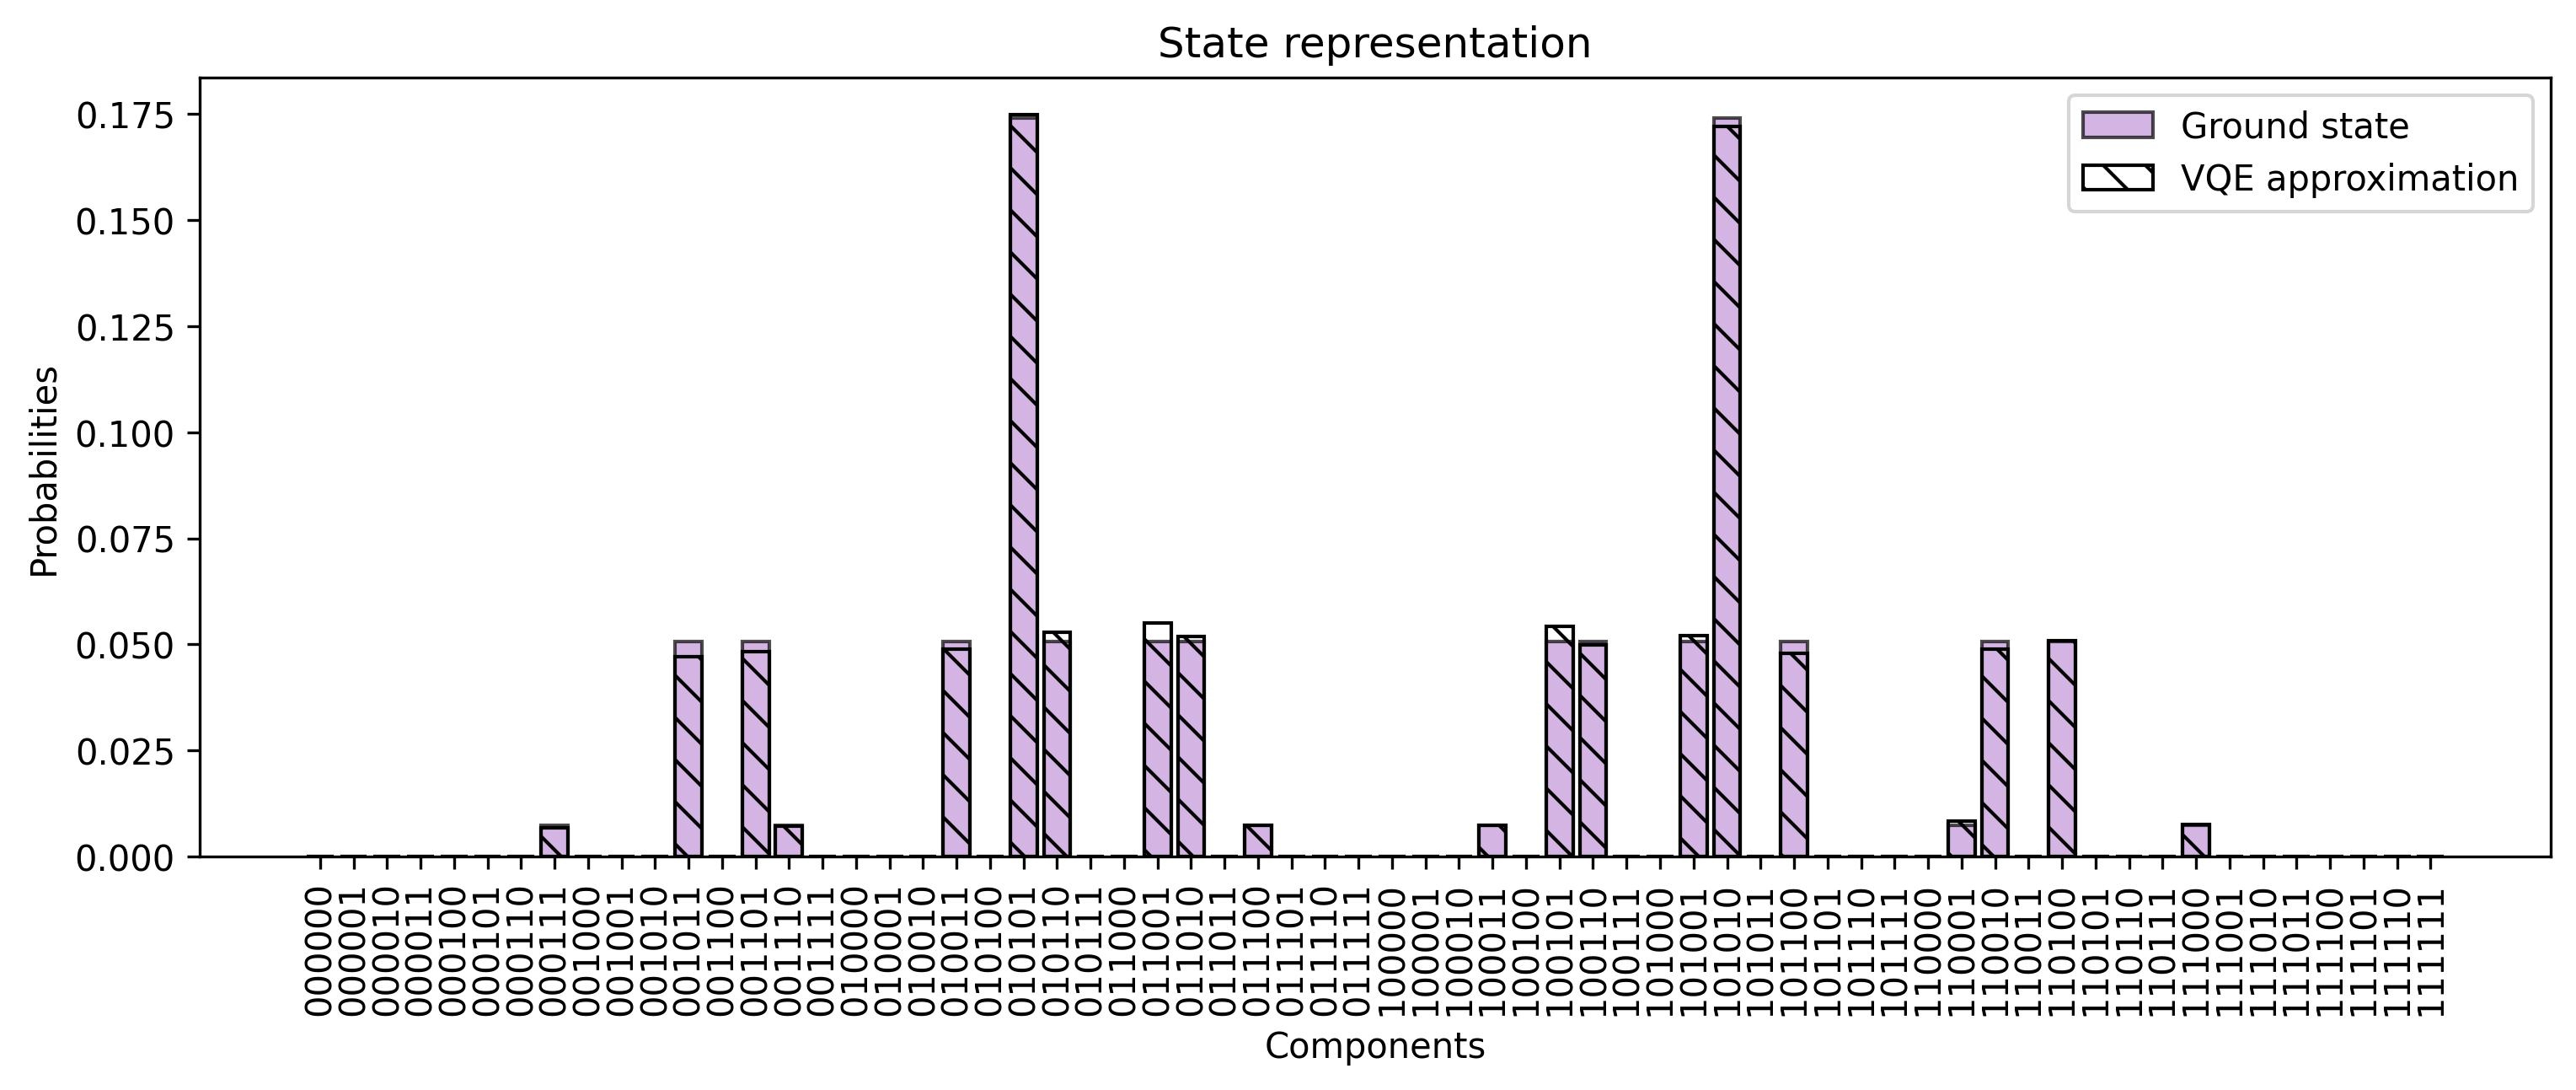

In [27]:
# Plotting Boosted VQE state
plot_vqe_states(ground_state, vqe1.circuit().state())

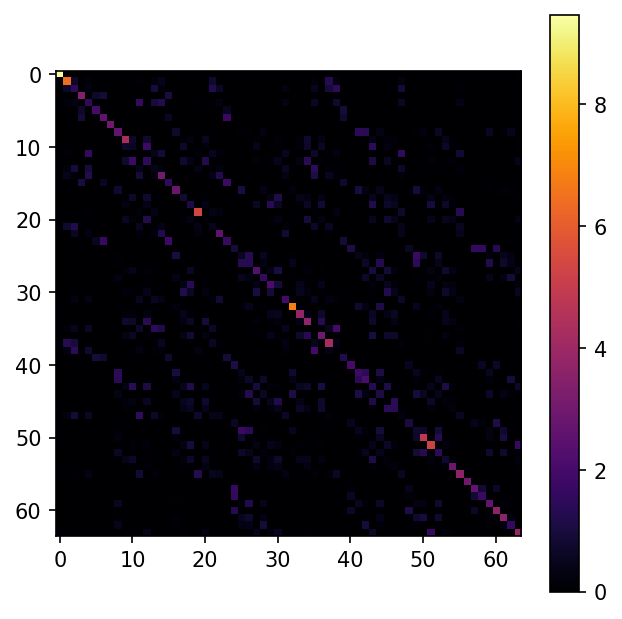

In [28]:
# Hamiltonian after 3 DBI steps
visualize_matrix(dbi.h.matrix)

### Apply GCI (you are allowed to turn off your brain here 😇)

Now I will show you how to do the same but using a GCI, namely a synthetized and compiled version of the DBI.
I will not delve deep inside the compilation itelf but show you the tools that can be extracted from `boostvqe` to explore it.

In [29]:
# CMA will be faster on numpy backend
qibo.set_backend("numpy")

[Qibo 0.2.14|INFO|2024-12-05 12:44:21]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


As the last time, we define a loss function which quantifies the quality of 1 GCI step action. This time we don't focus on the diagonalization, but on the ground state preparation. For this reason, we use as cost function the energy of the target input over the prepared state (instead of the off-diagonal norm of the other exercise).

In [49]:
def loss_function_gci(
    params, 
    gci,
    ham,
    dbr_mode,
):
    """Execute a copy of GCI and compute expval."""
    gci_copy = copy.deepcopy(gci)
    # collect parameters

    eo_d_type = IsingNNEvolutionOracle
    eo_d = eo_d_type.load(params[1:])
    
    gci_copy(step_duration=params[0], diagonal_association=eo_d, mode_dbr=dbr_mode)
    gci_circuit = gci_copy.get_composed_circuit()

    return ham.expectation(gci_circuit().state())

def optimize_GCI(
    gci, 
    params, 
    ham,
    dbr_mode,
    s_bounds=(1e-4, 1.), 
    b_bounds=(0., 9.),
):
    """
    Optimize all hyper-parameters of the GCI, namely the stepsize and the alphas and betas
    which parametrize the D operator.
    """

    lower_bounds = s_bounds[0] + b_bounds[0] * (len(params) - 1)
    upper_bounds = s_bounds[1] + b_bounds[1] * (len(params) - 1)
    bounds = [lower_bounds, upper_bounds]
    result = cma.fmin(
        loss_function_gci,
        sigma0=0.5,
        x0=params,
        args=(gci, ham, dbr_mode),
        options={"bounds": bounds, "maxiter": 100},
    )[0]
    return result

In [50]:
# XXZ hamiltonian oracle
# steps stand for time steps, while order is the Trotter-Suzuki order
base_oracle = XXZ_EvolutionOracle.from_nqubits(
    nqubits=nqubits, delta=0.5, steps=3, order=2
)

# This is implementing the frame shifting evolution oracle strategy 
# introduced by Marek in (https://arxiv.org/abs/2206.11772)
oracle = FrameShiftedEvolutionOracle.from_evolution_oracle(
    before_circuit=vqe.circuit.invert(),
    after_circuit=vqe.circuit,
    base_evolution_oracle=base_oracle,
)

# This is the synthetis strategy: third order group commutator formula with reduction
# namely dropping the first term not impacting in the cost function evaluation
dbr_type = DoubleBracketRotationType.group_commutator_third_order_reduced

# Here we are: the GCI
gci = GroupCommutatorIterationWithEvolutionOracles(
    input_hamiltonian_evolution_oracle=oracle,
    double_bracket_rotation_type=dbr_type,
)

In [51]:
# Collect and show the initial GCI circuit
gci_circuit = gci.get_composed_circuit()

print(f"GCI initial circuit:\n")
gci_circuit.draw()

print(f"\n\nGCI initial circuit summary:\n")
print(gci_circuit.summary())

GCI initial circuit:

0:     ─X─RBS─────────────────RBS─RBS─────────RBS─────RBS─────────────────RBS ...
1:     ─X─RBS─────────RBS─────|───|───────RBS─|───────RBS─────────RBS─────|── ...
2:     ─X─────RBS─────RBS─────|───RBS─────|───|───────────RBS─────RBS─────|── ...
3:     ───────RBS─────────RBS─|───────RBS─RBS─|───RBS─────RBS─────────RBS─|── ...
4:     ───────────RBS─────RBS─|───────|───────RBS─|───────────RBS─────RBS─|── ...
5:     ───────────RBS─────────RBS─────RBS─────────RBS─────────RBS─────────RBS ...

0: ... ─RBS─────────RBS─────RBS─────────────────RBS─RBS─────────RBS─────
1: ... ─|───────RBS─|───────RBS─────────RBS─────|───|───────RBS─|───────
2: ... ─RBS─────|───|───────────RBS─────RBS─────|───RBS─────|───|───────
3: ... ─────RBS─RBS─|───RBS─────RBS─────────RBS─|───────RBS─RBS─|───RBS─
4: ... ─────|───────RBS─|───────────RBS─────RBS─|───────|───────RBS─|───
5: ... ─────RBS─────────RBS─────────RBS─────────RBS─────RBS─────────RBS─


GCI initial circuit summary:

Circuit depth =

In [52]:
# Defining the parametrization of the D operator
eo_d_type = IsingNNEvolutionOracle

# Initial parameters for the parametrization
np.random.seed(4242)
params = [0.01]
params.extend(np.random.uniform(0., 9., nqubits * 2))

# This command can be used to load the parameters
eo_d = eo_d_type.load(params[1:])

In [53]:
# Reconstructing the Hamiltonian in the new (numpy) backend 
h0 = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)

In [54]:
# Optimizing the GCI
opt_results = optimize_GCI(
    gci=gci,
    params=params,
    ham=h0,
    dbr_mode=dbr_type,
)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 13 (seed=460071, Thu Dec  5 13:00:45 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 -8.612944990554558e+00 1.0e+00 4.72e-01  5e-01  5e-01 0:01.1
    2     22 -8.993904338859924e+00 1.1e+00 4.68e-01  4e-01  5e-01 0:02.2
    3     33 -9.427638446814093e+00 1.2e+00 4.97e-01  5e-01  5e-01 0:03.1
    7     77 -9.368333636731379e+00 1.7e+00 7.38e-01  6e-01  8e-01 0:07.0
   12    132 -8.962630273922636e+00 2.0e+00 8.57e-01  6e-01  1e+00 0:11.6
   18    198 -8.821416294192938e+00 2.3e+00 8.29e-01  5e-01  9e-01 0:17.3
   24    264 -9.402534288598467e+00 2.9e+00 7.76e-01  4e-01  1e+00 0:23.3
   32    352 -9.151087412928774e+00 4.2e+00 8.76e-01  4e-01  1e+00 0:31.0
   41    451 -9.266629263773513e+00 5.7e+00 7.64e-01  2e-01  1e+00 0:39.9
   51    561 -9.412746946548911e+00 7.6e+00 5.70e-01  1e-01  7e-01 0:49.6
   61    671 -9.405329361710935e+00 9.2e+00 4.02e-01  7e-02  5e-01 1:00.3
   73    803 -9.413467

In [55]:
# Collect best params
step_duration = opt_results[0]
d_params = opt_results[1:]

In [56]:
# Update the EvolutionOracle with those best params
eo_d = eo_d_type.load(d_params)

In [57]:
# The GCI is still untouched for now
print(gci.get_composed_circuit().summary())

Circuit depth = 16
Total number of gates = 36
Number of qubits = 6
Most common gates:
rbs: 33
x: 3


In [58]:
# Execute an optimized GCI
gci(step_duration=step_duration, diagonal_association=eo_d, mode_dbr=dbr_type)

In [59]:
# Collect the circuit
gci_circuit = gci.get_composed_circuit()

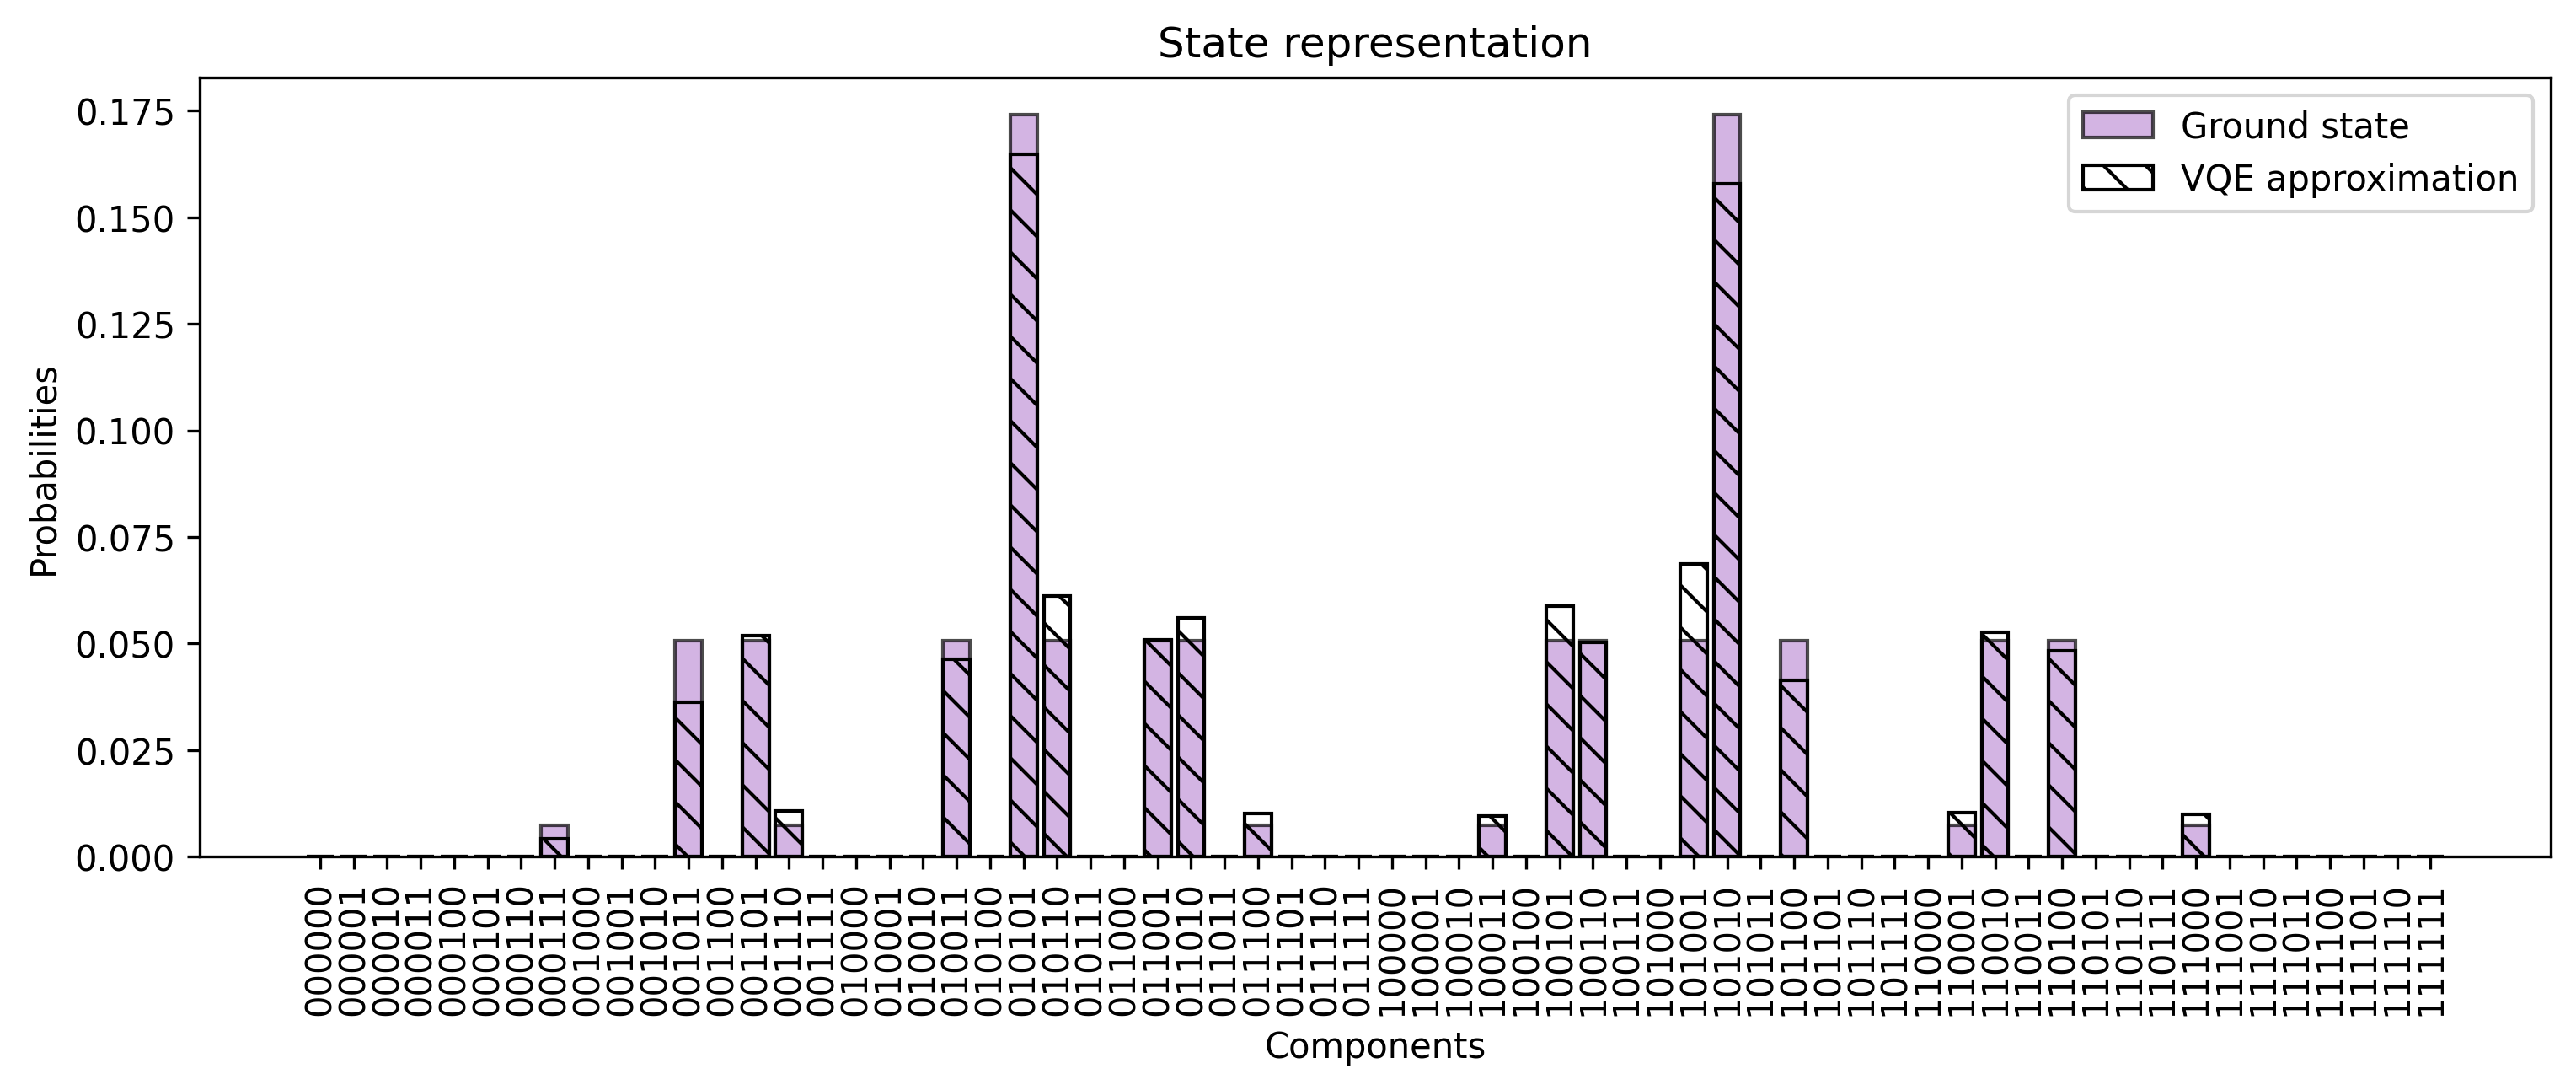

In [60]:
# Plot the GCI state
plot_vqe_states(ground_state, gci_circuit().state())

In [61]:
# Collect and show the new GCI circuit
gci_circuit = gci.get_composed_circuit()

print(f"GCI compiled circuit:\n")
gci_circuit.draw()

print(f"\n\nGCI compiled circui summary:\n")
print(gci_circuit.summary())

GCI compiled circuit:

0:     ─o────o─────────────────────────────X─RZ─X─RZ─X─RBS─────────────────RB ...
1:     ─X─RZ─X─o────o──────────────────────|────|─RZ─X─RBS─────────RBS─────|─ ...
2:     ────────X─RZ─X─o────o───────────────|────|─RZ─X─────RBS─────RBS─────|─ ...
3:     ───────────────X─RZ─X─o────o────────|────|─RZ───────RBS─────────RBS─|─ ...
4:     ──────────────────────X─RZ─X─o────o─|────|─RZ───────────RBS─────RBS─|─ ...
5:     ─────────────────────────────X─RZ─X─o────o─RZ───────────RBS─────────RB ...

0: ... S─RBS─────────RBS─────RBS─────────────────RBS─RBS─────────RBS─────RBS─ ...
1: ... ──|───────RBS─|───────RBS─────────RBS─────|───|───────RBS─|───────RBS─ ...
2: ... ──RBS─────|───|───────────RBS─────RBS─────|───RBS─────|───|─────────── ...
3: ... ──────RBS─RBS─|───RBS─────RBS─────────RBS─|───────RBS─RBS─|───RBS───── ...
4: ... ──────|───────RBS─|───────────RBS─────RBS─|───────|───────RBS─|─────── ...
5: ... S─────RBS─────────RBS─────────RBS─────────RBS─────RBS─────────RBS──